In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.model_selection import train_test_split
from surprise.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
# from sklearn.externals import joblib
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from surprise import Reader, Dataset, SVD, accuracy
from surprise import KNNWithMeans

In [2]:
electronics_data=pd.read_csv("ratings_Electronics.csv",names=['userId', 'productId','Rating','timestamp'])

In [3]:
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
# Handle missing values
print('Number of missing values: \n',electronics_data.isnull().sum())


Number of missing values: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


In [5]:
electronics_data.shape

(7824482, 4)

In [6]:
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


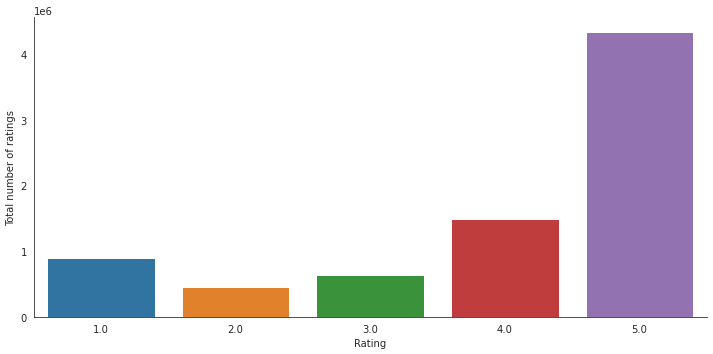

In [7]:
with sns.axes_style('white'):
    g = sns.catplot(x="Rating", data=electronics_data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [8]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",electronics_data.shape[0])
print("Total No of Users   :", len(np.unique(electronics_data.userId)))
print("Total No of products  :", len(np.unique(electronics_data.productId)))

Total data 
--------------------------------------------------

Total no of ratings : 7824482
Total No of Users   : 4201696
Total No of products  : 476002


In [9]:
#Dropping the Timestamp column

electronics_data.drop(['timestamp'], axis=1,inplace=True)

electronics_data.head()

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [10]:
electronics_data[electronics_data.duplicated()].any()
# rating describe summary 
electronics_data.describe()['Rating']


count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [11]:
print("Unique value of Rating:",electronics_data.Rating.unique())
print('Minimum rating is: %d' %(electronics_data.Rating.min()))
print('Maximum rating is: %d' %(electronics_data.Rating.max()))

Unique value of Rating: [5. 1. 3. 2. 4.]
Minimum rating is: 1
Maximum rating is: 5


In [12]:
ratings = pd.DataFrame(electronics_data.groupby('productId')['Rating'].mean())
ratings['ratings_count'] = pd.DataFrame(electronics_data.groupby('productId')['Rating'].count())
ratings['ratings_average'] = pd.DataFrame(electronics_data.groupby('productId')['Rating'].mean())
ratings.head(10)

,Rating,ratings_count,ratings_average
productId,,,
0132793040,5.000000,1,5.000000
0321732944,5.000000,1,5.000000
0439886341,1.666667,3,1.666667
0511189877,4.500000,6,4.500000
0528881469,2.851852,27,2.851852
0558835155,3.000000,1,3.000000
059400232X,5.000000,3,5.000000
0594012015,2.000000,8,2.000000
0594017343,1.000000,1,1.000000


In [13]:
vote_counts = ratings[ratings['ratings_count'].notnull()]['ratings_count'].astype('int')
vote_averages = ratings[ratings['ratings_average'].notnull()]['ratings_average'].astype('int')
C = vote_averages.mean()
print("Average rating of product across the whole dataset is",C)

Average rating of product across the whole dataset is 3.6646757786731987


In [14]:
m = vote_counts.quantile(0.95)
print("Minimum votes required to be listed in the chart is",m)

Minimum votes required to be listed in the chart is 55.0


In [15]:
ratings.head()

,Rating,ratings_count,ratings_average
productId,,,
0132793040,5.000000,1,5.000000
0321732944,5.000000,1,5.000000
0439886341,1.666667,3,1.666667
0511189877,4.500000,6,4.500000
0528881469,2.851852,27,2.851852


In [16]:
qualified = ratings[(ratings['ratings_count'] >= m) & (ratings['ratings_count'].notnull()) & (ratings['ratings_average'].notnull())][['ratings_count', 'ratings_average']]

In [17]:
qualified['ratings_count'] = qualified['ratings_count'].astype('int')
qualified['ratings_average'] = qualified['ratings_average'].astype('int')
qualified.head().sort_values(by='ratings_count', ascending=False)

,ratings_count,ratings_average
productId,,
0972683275,1051,4
1400501466,250,3
1400532620,171,3
1400501776,139,3
1400501520,82,4


In [18]:
qualified.shape

(24014, 2)

In [19]:
def weighted_rating(x):
    v = x['ratings_count']
    R = x['ratings_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [20]:
qualified['weightedRatings'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('weightedRatings', ascending=False).head(20)
qualified.head(10)

,ratings_count,ratings_average,weightedRatings
productId,,,
B0074BW614,18244,4,3.998992
B007WTAJTO,14172,4,3.998704
B0019EHU8G,12285,4,3.998505
B006GWO5WK,12226,4,3.998498
B003ELYQGG,11617,4,3.998420
B003ES5ZUU,10276,4,3.998215
B007R5YDYA,9907,4,3.998149
B00622AG6S,9823,4,3.998133
B0002L5R78,9487,4,3.998067


Text(0, 0.5, 'Count')

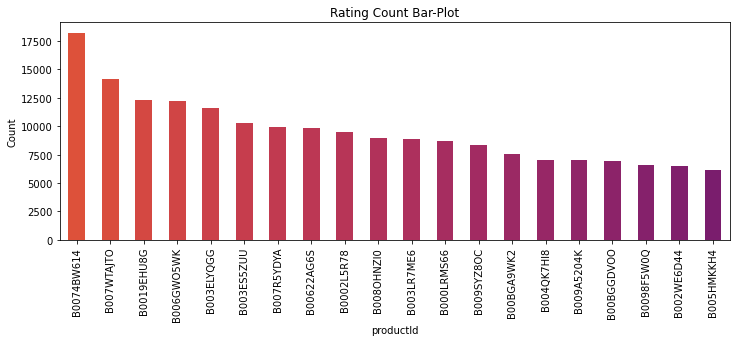

In [21]:
from matplotlib import cm
color = cm.inferno_r(np.linspace(.4, .8, 30))

rating_plot_count = qualified['ratings_count'].plot.bar(figsize=(12, 4),color=color)
rating_plot_count.set_title("Rating Count Bar-Plot")
rating_plot_count.set_xlabel("productId")
rating_plot_count.set_ylabel("Count")

Text(0, 0.5, 'rating')

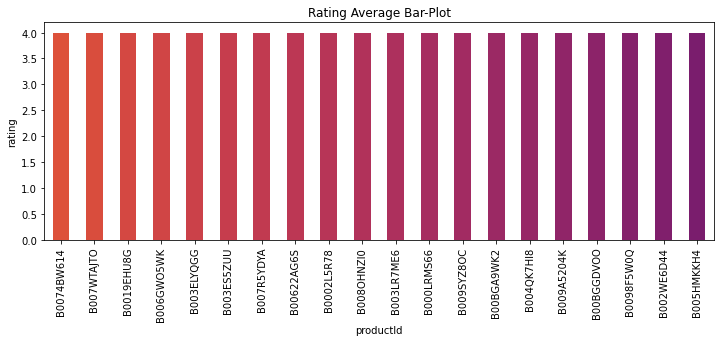

In [22]:
rating_plot_avg = qualified['ratings_average'].plot.bar(figsize=(12, 4),color=color)
rating_plot_avg.set_title("Rating Average Bar-Plot")
rating_plot_avg.set_xlabel("productId")
rating_plot_avg.set_ylabel("rating")

In [63]:
reader_object = Reader(rating_scale=(1, 5))
electronics_data_complete = electronics_data
# electronics_data = electronics_data[0:5000]
data = Dataset.load_from_df(electronics_data, reader_object)
train_set, test_set = train_test_split(data, test_size=0.3,random_state=10)

# Popularity Based Recommendation

            Rating
productId         
0972683275    1051
1400532655     484
140053271X     431
1400501466     250
1400599997     222
9573212919     199
1400532620     171
1400501776     139
1400698987     138
7214047977     107
9575871979      98
8862935293      95
1400532736      84
6301977173      83
1400501520      82
3744295508      60
1400699169      47
8866139874      38
9573212900      36
1615527613      32
0594481813      31
8918010656      29
1400501474      29
7538637400      28
0528881469      27
161552763X      26
8862935307      26
1400501741      26
5135000011      24
1394860919      23


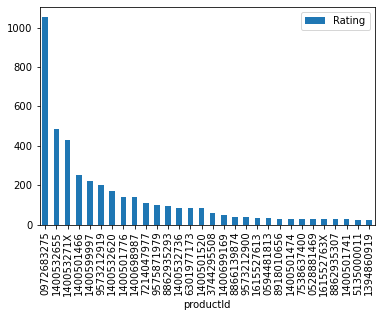

In [35]:
ratings_mean_count = pd.DataFrame(electronics_data.groupby('productId')['Rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(electronics_data.groupby('productId')['Rating'].count())


popular_products = pd.DataFrame(electronics_data.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(30).plot(kind = "bar")

print(most_popular.head(30))

# Collobarating Filtering

## SVD Algorithm

In [36]:
svd_model = SVD()
svd_model.fit(train_set)

In [37]:
svd_y_pred = svd_model.test(test_set)

In [38]:
accuracy.rmse(svd_y_pred)
accuracy.mse(svd_y_pred)
accuracy.mae(svd_y_pred)
accuracy.fcp(svd_y_pred)

RMSE: 1.3366
MSE: 1.7865
MAE:  1.0942
FCP:  1.0000


1.0

In [40]:
svd_model.predict('A3LDPF5FMB782Z', '140053271X', 5.0)

Prediction(uid='A3LDPF5FMB782Z', iid='140053271X', r_ui=5.0, est=4.0984923570960765, details={'was_impossible': False})

## KNN

In [30]:
data = []
# Preprocessing Data
df = electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)
new_data = Dataset.load_from_df(df,reader_object)
new_train_set, new_test_set = train_test_split(new_data, test_size=0.3,random_state=10)

In [31]:
knn_model = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
knn_model.fit(new_train_set)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [32]:
knn_y_pred = knn_model.test(new_test_set)

In [33]:
accuracy.rmse(knn_y_pred)
accuracy.mse(knn_y_pred)
accuracy.mae(knn_y_pred)
accuracy.fcp(knn_y_pred)

RMSE: 1.4116
MSE: 1.9927
MAE:  1.1183
FCP:  1.0000


1.0

# Recommendation Engine

In [69]:
df = electronics_data_complete.groupby("productId").filter(lambda x:x['Rating'].count() >=5)
ratings_matrix = df.pivot_table(values='Rating', index='userId', columns='productId', fill_value=0)
ratings_matrix.head()

productId,0511189877,0528881469,0594012015,0594033896,0594033926,0594296420,0594451647,0594481813,0594481902,0899336795,...,8991643515,9043413585,9269807207,9573212749,9573212897,9573212900,9573212919,9573213257,9574423271,9575871979
userId,,,,,,,,,,,,,,,,,,,,,
A00766851QZZUBOVF4JFT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0590501PZ7HOWJKBGQ4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A076219533YHEV2LJO988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
X = ratings_matrix.T
X.head()

X.shape

(83, 4606)

In [71]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(83, 10)

In [72]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(83, 83)

In [73]:
X.index[80]

'9573213257'

In [74]:
i = "9573213257"

product_names = list(X.index)
product_ID = product_names.index(i)

correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(83,)

In [75]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:10]

['0511189877',
 '0594012015',
 '0899336795',
 '1034385789',
 '1254875778',
 '1400699169',
 '1615527672',
 '1616874457',
 '1685560148',
 '3126743692']